# Results?
## Intro
Load in the graph, assign attributes, load our functions, etc.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import CommunityDiscovery,Helper,Projection,Similarity

In [2]:
df = pd.read_csv("../data/disease_edgelist.csv")
df_att = pd.read_csv("../data/disease_attributes.csv",index_col="Id")

Create the bipartite graph, assign attributes, and create a dictionary of subclass communities.

In [3]:
G = nx.convert_matrix.from_pandas_edgelist(df,"Source","Target",create_using=nx.Graph())
nx.set_node_attributes(G,df_att.to_dict(orient="index"))
subclass_coms = df_att.loc[df_att.Class == "disease","Subclass"].to_dict()

Get all our functions.

In [4]:
proj = Projection()
cd = CommunityDiscovery()
util = Helper()
sim = Similarity()

## Projections

In [5]:
hdn_simple,gdn_simple = proj.simple_weight(G,["Subclass"])
hdn_unw,gdn_unw = proj.unweight(G,["Subclass"])
hdn_ycn,gdn_ycn = proj.ycn(G,["Subclass"])

## Community discoveries
### Infomap

In [6]:
im_params = ["--two-level",
             "--num-trials 10",
             "--teleportation-probability 0.15",
             "--markov-time 1",
             "--core-loop-limit 10",
             "--tune-iteration-threshold 1e-5"]

Run infomap on all the projections.

In [7]:
hdn_simple,simple_info_coms = cd.infomap_detect(hdn_simple,parameters=im_params)
hdn_unw,unw_info_coms = cd.infomap_detect(hdn_unw,parameters=im_params)
hdn_ycn,ycn_info_coms = cd.infomap_detect(hdn_ycn,parameters=im_params)

Found 51 modules with codelength: 4.679897251186614
Found 53 modules with codelength: 4.775851099497053
Found 54 modules with codelength: 4.66640180792172


### Greedy modularization
Run greedy modularization on all the projections.

In [8]:
hdn_simple,simple_greedy_coms = cd.greedy(hdn_simple)
hdn_unw,unw_greedy_coms = cd.greedy(hdn_unw)
hdn_ycn,ycn_greedy_coms = cd.greedy(hdn_ycn)

## Normalized mutual information
This is hard-coded.

In [9]:
coms = {"Simple weight with infomap":simple_info_coms,
        "Simple weight with greedy modu":simple_greedy_coms,
        "Unweight with infomap":unw_info_coms,
        "Unweight with greedy modu":unw_greedy_coms,
        "YCN-RW with infomap":ycn_info_coms,
        "YCN-RW with greedy modu":ycn_greedy_coms,
        'Subclass communities ("Ground truth")':subclass_coms}

In [10]:
nmis = np.ones((len(coms),len(coms)))

In [11]:
for idx1,com1 in enumerate(coms):
    for idx2,com2 in enumerate(coms):
        if idx1 == idx2:
            continue
        elif idx2 < idx1:
            nmis[idx1,idx2] = sim.norm_mutual_info(coms[com1],coms[com2])
        else:
            nmis[idx1,idx2] = sim.norm_mutual_info(coms[com1],coms[com2])
            print("NMI for {} and {} is {:.3f}".format(com1,com2,nmis[idx1,idx2]))

NMI for Simple weight with infomap and Simple weight with greedy modu is 0.846
NMI for Simple weight with infomap and Unweight with infomap is 0.961
NMI for Simple weight with infomap and Unweight with greedy modu is 0.849
NMI for Simple weight with infomap and YCN-RW with infomap is 0.919
NMI for Simple weight with infomap and YCN-RW with greedy modu is 0.703
NMI for Simple weight with infomap and Subclass communities ("Ground truth") is 0.493
NMI for Simple weight with greedy modu and Unweight with infomap is 0.848
NMI for Simple weight with greedy modu and Unweight with greedy modu is 0.995
NMI for Simple weight with greedy modu and YCN-RW with infomap is 0.836
NMI for Simple weight with greedy modu and YCN-RW with greedy modu is 0.821
NMI for Simple weight with greedy modu and Subclass communities ("Ground truth") is 0.435
NMI for Unweight with infomap and Unweight with greedy modu is 0.851
NMI for Unweight with infomap and YCN-RW with infomap is 0.901
NMI for Unweight with infomap

In [12]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor",bottom=False,left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


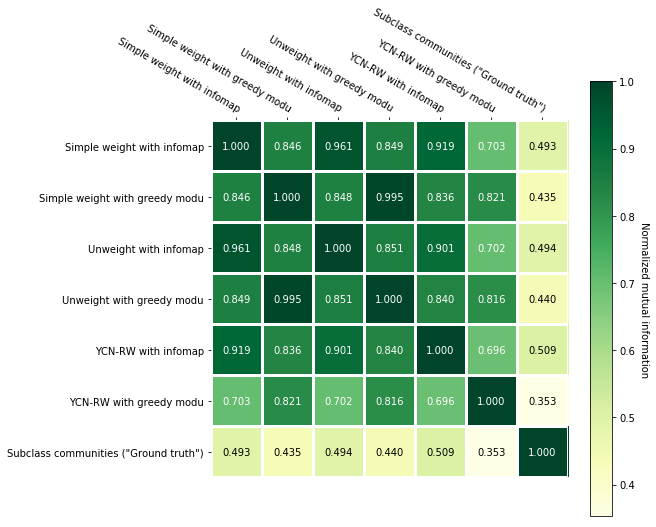

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

im, cbar = heatmap(nmis,coms.keys(),coms.keys(),ax=ax,cmap="YlGn",cbarlabel="Normalized mutual information")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.show()

## Community plots
### Simple weight

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


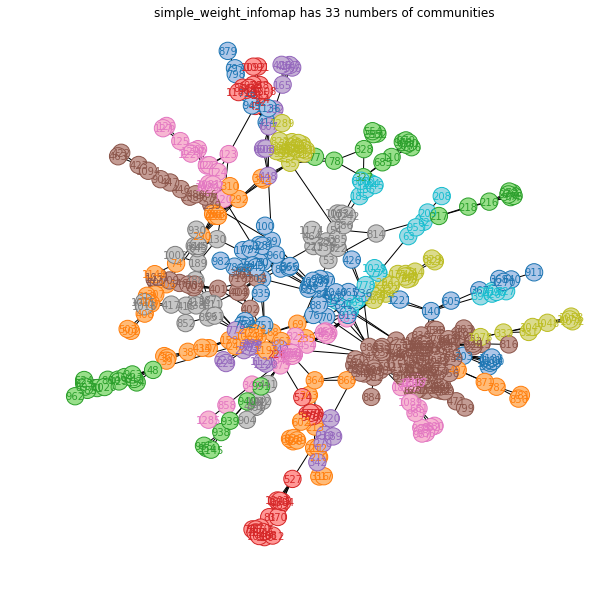

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_simple,ax,com_name="infomap",proj_name="simple_weight")
plt.show()

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


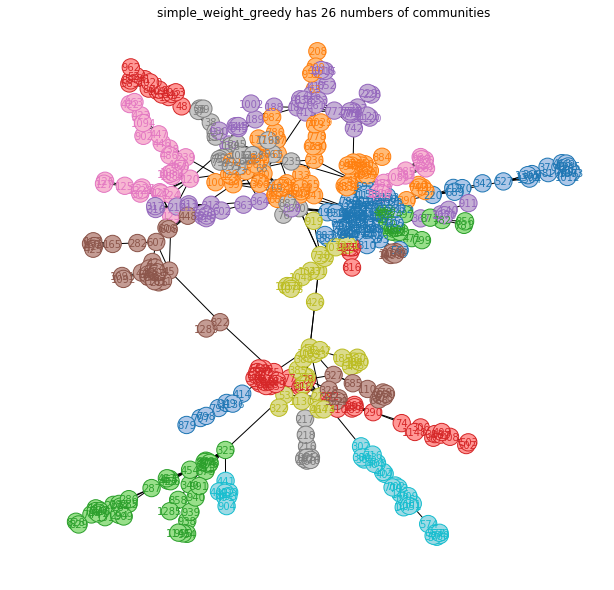

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_unw,ax,com_name="greedy",proj_name="simple_weight")
plt.show()

### Unweight

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


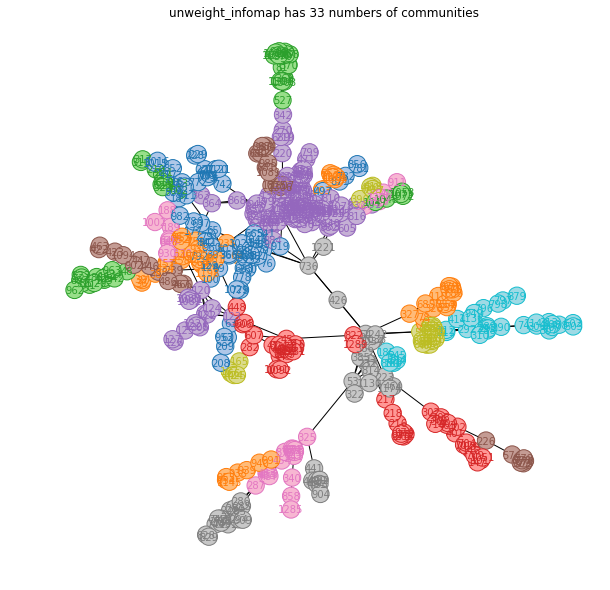

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_unw,ax,com_name="infomap",proj_name="unweight")
plt.show()

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


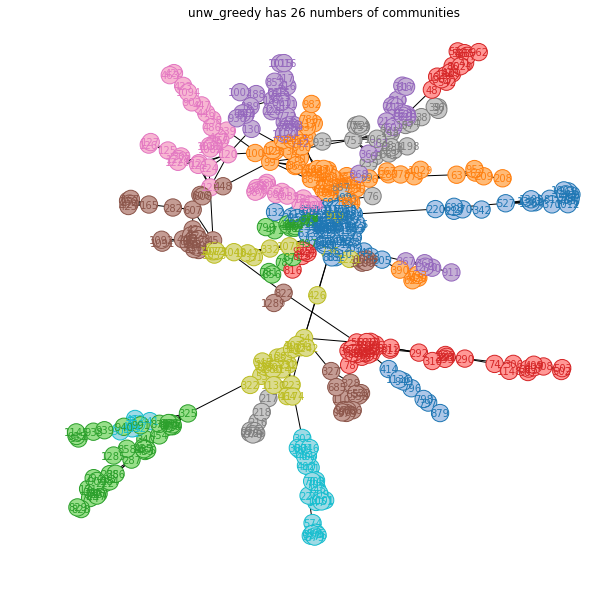

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_unw,ax,com_name="greedy",proj_name="unw")
plt.show()

### YCN-RW

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


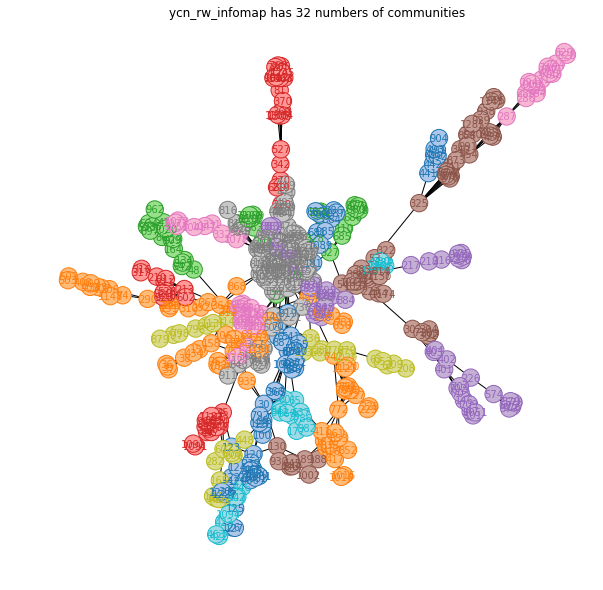

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_ycn,ax,com_name="infomap",proj_name="ycn_rw")
plt.show()

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


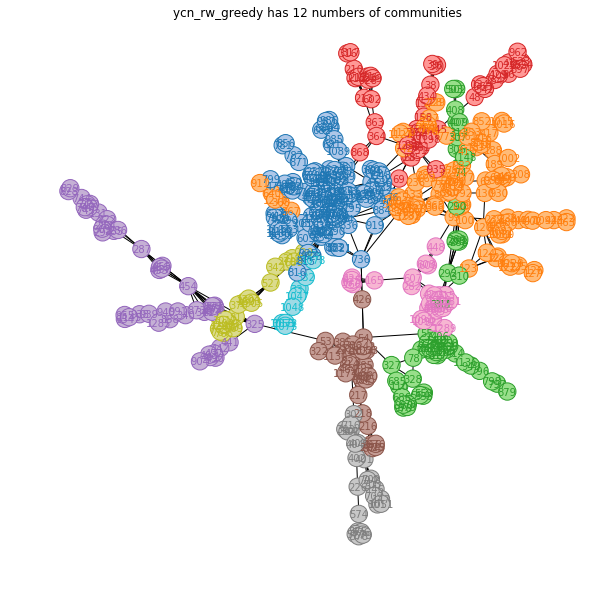

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_ycn,ax,com_name="greedy",proj_name="ycn_rw")
plt.show()

### Subclass

In [58]:
subclass_dict = dict()
subclass_coms = pd.factorize([val for val in nx.get_node_attributes(hdn_simple,"Subclass").values()])[0]

In [60]:
for idx,node in enumerate(nx.get_node_attributes(hdn_simple,"Subclass")):
    subclass_dict[node] = subclass_coms[idx]
nx.set_node_attributes(hdn_simple,subclass_dict,"subclass")

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


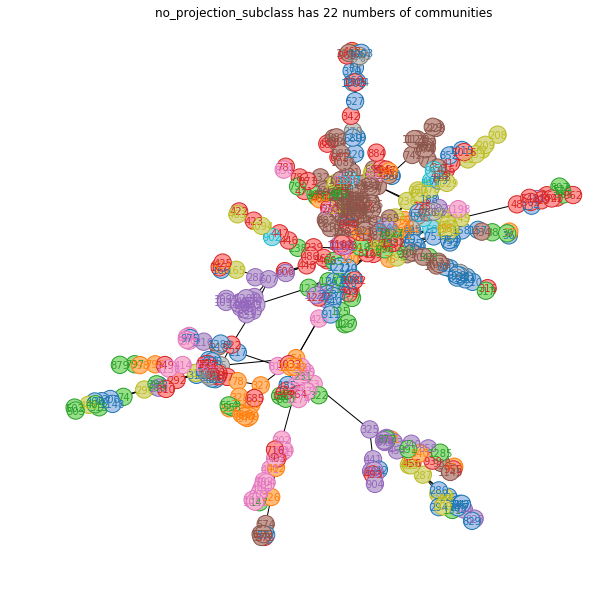

In [62]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
util.drawCommunities(hdn_simple,ax,com_name="subclass",proj_name="no_projection")
plt.show()

## Community Stacked plots
### simple weight

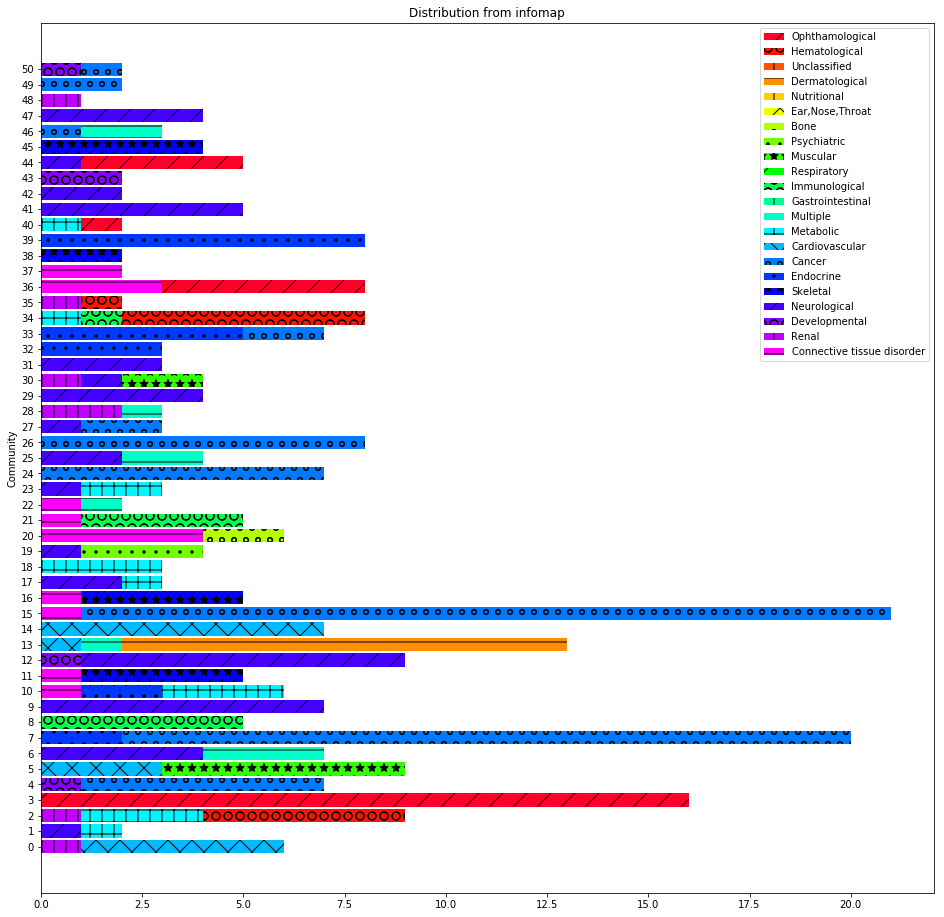

In [17]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_simple,"infomap")

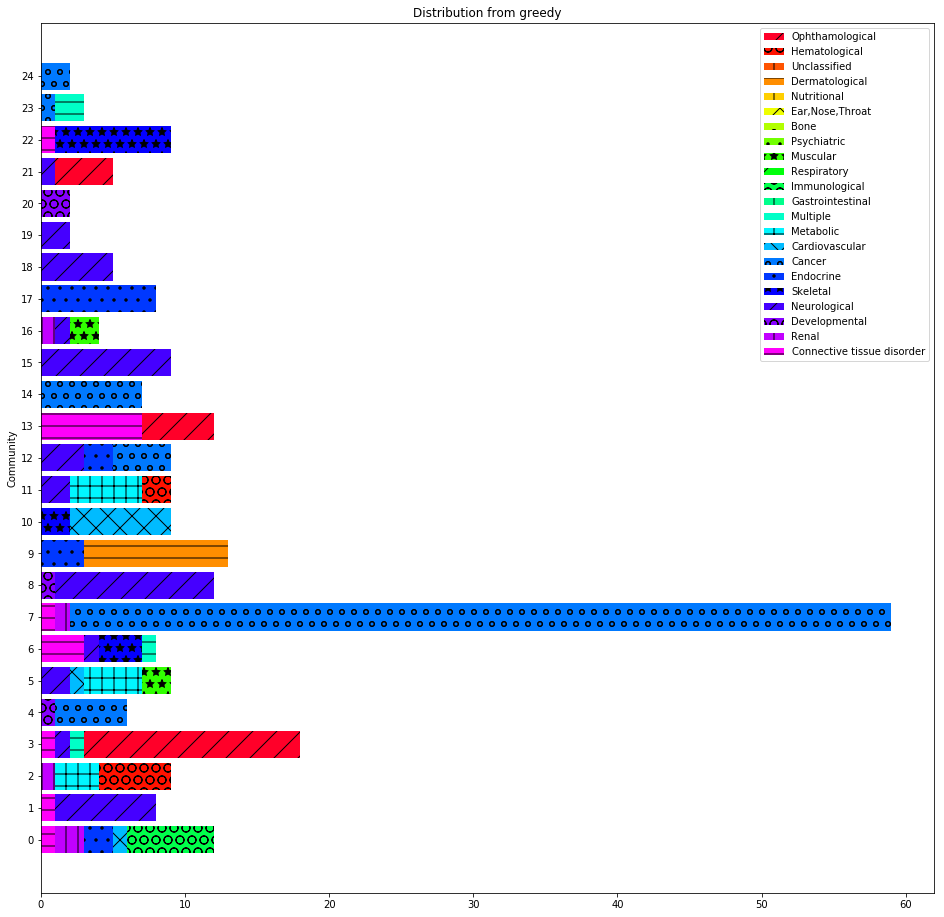

In [18]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_simple,"greedy")

### Unweight

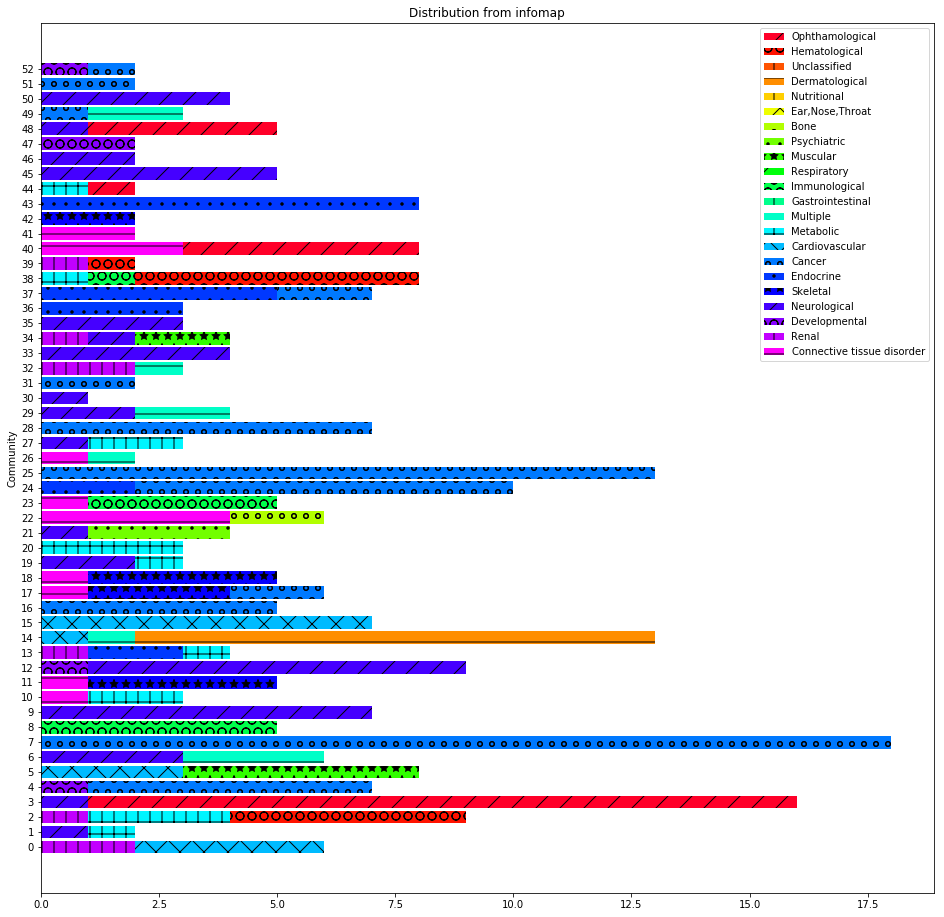

In [19]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_unw,"infomap")

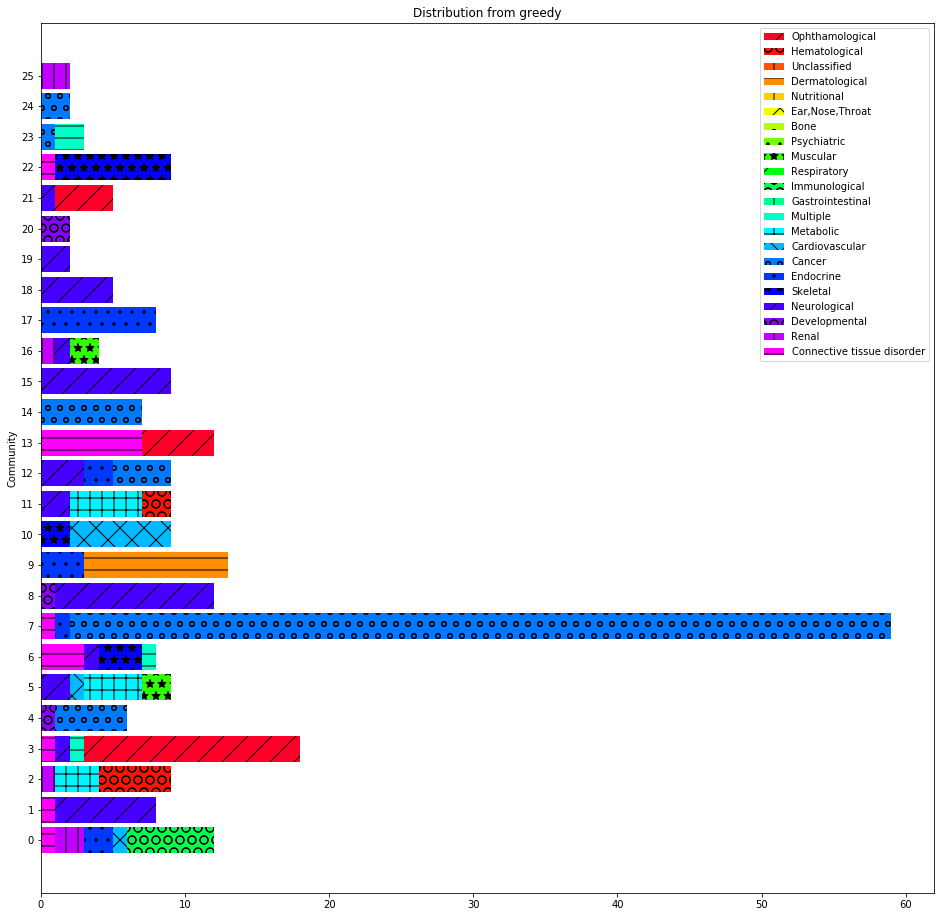

In [20]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_unw,"greedy")

### Ycn

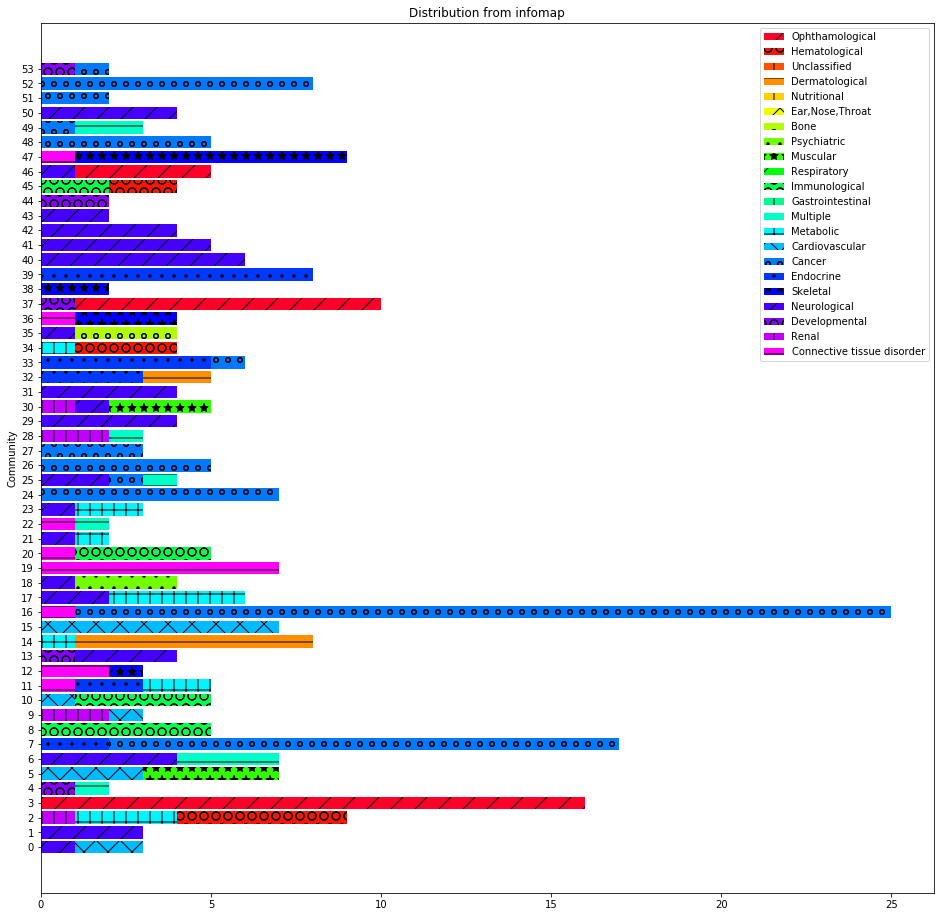

In [21]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_ycn,"infomap")

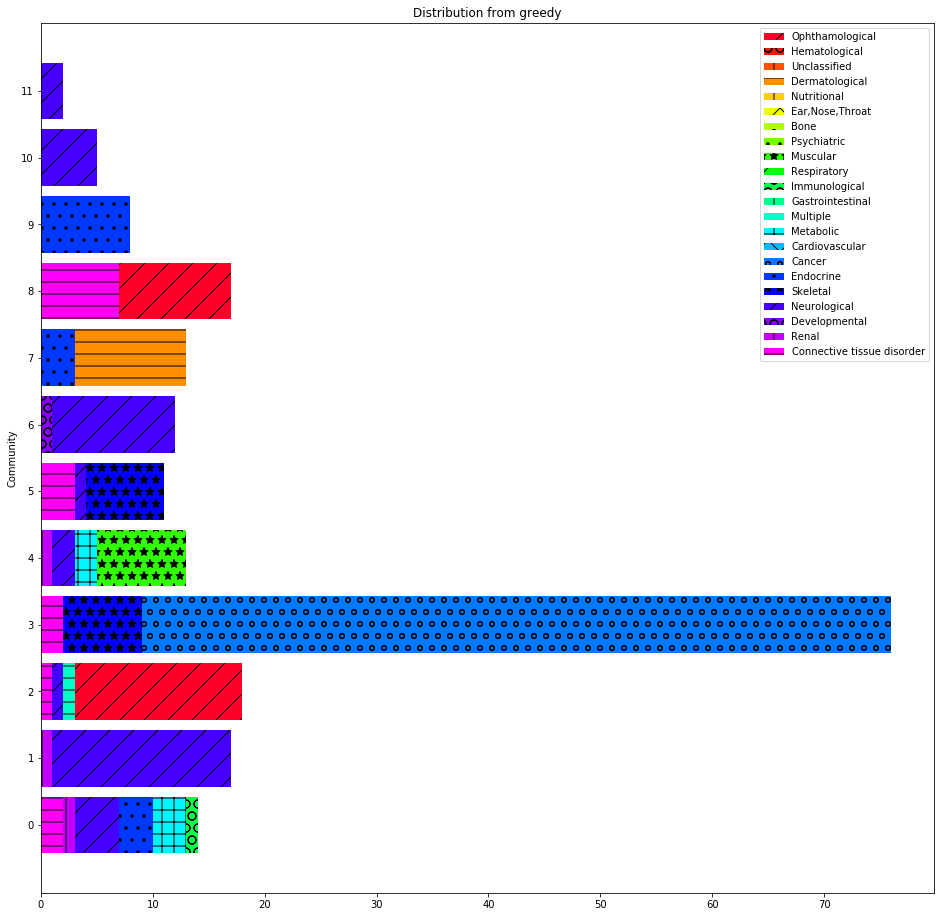

In [22]:
fig = plt.figure(figsize=(16,16))
util.stack_plot(hdn_ycn,"greedy")